In [2]:
import pandas as pd
import numpy as np
import datetime
import re
from collections import Counter

## Load Data
- session
  - drop : expired_at=NaN
  - add 9 hours : created_at, expired_at, login_at
- click
- view
- like
  - drop : is_deleted=True
  - add 9 hours : timestamp

In [3]:
def process_timestamp(df: pd.DataFrame, col: str):
    mask = df[col].notna()
    df.loc[mask, col] = pd.to_datetime(df.loc[mask, col]) + datetime.timedelta(hours=9)
    df.loc[mask, col] = df.loc[mask, col].apply(lambda x: x.strftime("%y-%m-%d %H:%M:%S"))

In [4]:
session = pd.read_csv("../data/session.csv")
# session = session.dropna(subset=['expired_at'], axis=0).reset_index(drop=True)

for col in ['created_at', 'expired_at', 'login_at']:
    process_timestamp(session, col)

session

,session_id,user_id,created_at,login_at,expired_at
0,59328bf5-bb18-4163-a6e4-a52c056742b1,NaN,23-07-19 08:44:04,NaN,NaN
1,d81c857c-d590-45fe-b690-bf3c119678b0,NaN,23-07-19 08:44:06,NaN,NaN
2,2d732e6b-099c-4bbf-8c04-e06c7099ae6b,NaN,23-07-19 08:59:35,NaN,NaN
3,ee08281b-cc15-489e-9071-3b5d17d6d87d,NaN,23-07-19 08:59:37,NaN,NaN
4,19c8cd7d-4cf5-4e0b-8336-844054c7491a,NaN,23-07-19 08:44:34,NaN,NaN
...,...,...,...,...,...
8998,9b8e54aa-8c85-4e2c-9170-9791bc7695af,NaN,23-07-21 09:56:24,NaN,NaN
8999,1d768f80-417f-4168-b8e0-2d9598951d4a,NaN,23-07-21 10:01:24,NaN,NaN
9000,18e81c43-6cbc-4bda-8dd5-18f10d7bad6e,NaN,23-07-21 10:06:25,NaN,NaN
9001,49451081-7406-4368-a3fd-3d558a6c7ce5,NaN,23-07-21 10:16:24,NaN,NaN


In [5]:
click_0719 = pd.read_csv("../data/2023-07-19/click_image_log.txt")
click_0720 = pd.read_csv("../data/2023-07-20/click_image_log.txt")
click_0721 = pd.read_csv("../data/2023-07-21/click_image_log.txt")
click = pd.concat([click_0719, click_0720, click_0721], axis=0, ignore_index=True)
click

,session_id,user_id,outfit_id,timestamp,click_type
0,7708c8e7-4292-4ff9-99b1-27be20427e42,1,83783,23-07-19 09:26:07,collection
1,7708c8e7-4292-4ff9-99b1-27be20427e42,1,83800,23-07-19 09:26:10,similar
2,7708c8e7-4292-4ff9-99b1-27be20427e42,1,83791,23-07-19 09:26:12,similar
3,7708c8e7-4292-4ff9-99b1-27be20427e42,1,84029,23-07-19 09:26:16,similar
4,7708c8e7-4292-4ff9-99b1-27be20427e42,1,83706,23-07-19 09:26:18,similar
...,...,...,...,...,...
1235,39767e97-0a22-498a-9c63-656be7cf3ce2,0,87304,23-07-21 07:40:55,similar
1236,39767e97-0a22-498a-9c63-656be7cf3ce2,0,87305,23-07-21 07:40:57,similar
1237,22af75f5-cabe-46e8-90b3-08613327f389,0,83358,23-07-21 09:17:11,journey
1238,22af75f5-cabe-46e8-90b3-08613327f389,0,90364,23-07-21 09:19:07,journey


In [6]:
view_0719 = pd.read_csv("../data/2023-07-19/view_image_log.txt")
view_0720 = pd.read_csv("../data/2023-07-20/view_image_log.txt")
view_0721 = pd.read_csv("../data/2023-07-21/view_image_log.txt")
view = pd.concat([view_0719, view_0720, view_0721], axis=0, ignore_index=True)
view

,session_id,user_id,outfit_id,timestamp,view_type
0,0fd3b801-76f1-4f4e-bafb-5884fbcfcf7f,0,79850,23-07-19 09:00:05,journey
1,0fd3b801-76f1-4f4e-bafb-5884fbcfcf7f,0,89945,23-07-19 09:00:05,journey
2,0fd3b801-76f1-4f4e-bafb-5884fbcfcf7f,0,85067,23-07-19 09:00:05,journey
3,0fd3b801-76f1-4f4e-bafb-5884fbcfcf7f,0,81371,23-07-19 09:00:05,journey
4,0fd3b801-76f1-4f4e-bafb-5884fbcfcf7f,0,71531,23-07-19 09:00:05,journey
...,...,...,...,...,...
29345,93233da9-9d08-49ac-a6a6-177a4c4fb81f,0,82692,23-07-21 09:59:32,journey
29346,93233da9-9d08-49ac-a6a6-177a4c4fb81f,0,89698,23-07-21 09:59:32,journey
29347,93233da9-9d08-49ac-a6a6-177a4c4fb81f,0,73424,23-07-21 09:59:32,journey
29348,93233da9-9d08-49ac-a6a6-177a4c4fb81f,0,79117,23-07-21 09:59:32,journey


In [7]:
like = pd.read_csv("../data/like.csv")
like = like[like['is_deleted']==False]
like['timestamp'] = pd.to_datetime(like['timestamp']) + datetime.timedelta(hours=9)
like['timestamp'] = pd.to_datetime(like['timestamp']).apply(lambda x: x.strftime("%y-%m-%d %H:%M:%S"))
like = like.drop(columns=["like_id"]).reset_index(drop=True)
like

,session_id,user_id,outfit_id,timestamp,like_type,is_deleted,as_login
0,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,73016,23-07-19 08:53:25,journey,False,False
1,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,79507,23-07-19 08:53:25,journey,False,False
2,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88572,23-07-19 08:53:53,journey,False,False
3,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88731,23-07-19 08:53:54,journey,False,False
4,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,78346,23-07-19 08:53:55,journey,False,False
...,...,...,...,...,...,...,...
1009,22af75f5-cabe-46e8-90b3-08613327f389,NaN,83291,23-07-21 09:18:48,journey,False,False
1010,22af75f5-cabe-46e8-90b3-08613327f389,NaN,91336,23-07-21 09:19:34,journey,False,False
1011,22af75f5-cabe-46e8-90b3-08613327f389,NaN,91601,23-07-21 09:20:03,journey,False,False
1012,22af75f5-cabe-46e8-90b3-08613327f389,NaN,90043,23-07-21 09:20:13,journey,False,False


In [8]:
like_click = pd.concat([like, click], axis=0, ignore_index=True)
like_click

,session_id,user_id,outfit_id,timestamp,like_type,is_deleted,as_login,click_type
0,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,73016,23-07-19 08:53:25,journey,False,False,NaN
1,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,79507,23-07-19 08:53:25,journey,False,False,NaN
2,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88572,23-07-19 08:53:53,journey,False,False,NaN
3,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88731,23-07-19 08:53:54,journey,False,False,NaN
4,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,78346,23-07-19 08:53:55,journey,False,False,NaN
...,...,...,...,...,...,...,...,...
2249,39767e97-0a22-498a-9c63-656be7cf3ce2,0.0,87304,23-07-21 07:40:55,NaN,NaN,NaN,similar
2250,39767e97-0a22-498a-9c63-656be7cf3ce2,0.0,87305,23-07-21 07:40:57,NaN,NaN,NaN,similar
2251,22af75f5-cabe-46e8-90b3-08613327f389,0.0,83358,23-07-21 09:17:11,NaN,NaN,NaN,journey
2252,22af75f5-cabe-46e8-90b3-08613327f389,0.0,90364,23-07-21 09:19:07,NaN,NaN,NaN,journey


In [9]:
like_click = like_click.drop_duplicates(subset=['session_id', 'outfit_id'], keep='last')
like_click

,session_id,user_id,outfit_id,timestamp,like_type,is_deleted,as_login,click_type
0,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,73016,23-07-19 08:53:25,journey,False,False,NaN
1,66178898-dfb6-4de4-8f2a-cb09e3ccbe11,NaN,79507,23-07-19 08:53:25,journey,False,False,NaN
2,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88572,23-07-19 08:53:53,journey,False,False,NaN
3,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,88731,23-07-19 08:53:54,journey,False,False,NaN
4,7221dea7-71a9-4387-9a0e-96325662b63b,NaN,78346,23-07-19 08:53:55,journey,False,False,NaN
...,...,...,...,...,...,...,...,...
2249,39767e97-0a22-498a-9c63-656be7cf3ce2,0.0,87304,23-07-21 07:40:55,NaN,NaN,NaN,similar
2250,39767e97-0a22-498a-9c63-656be7cf3ce2,0.0,87305,23-07-21 07:40:57,NaN,NaN,NaN,similar
2251,22af75f5-cabe-46e8-90b3-08613327f389,0.0,83358,23-07-21 09:17:11,NaN,NaN,NaN,journey
2252,22af75f5-cabe-46e8-90b3-08613327f389,0.0,90364,23-07-21 09:19:07,NaN,NaN,NaN,journey


<Axes: >

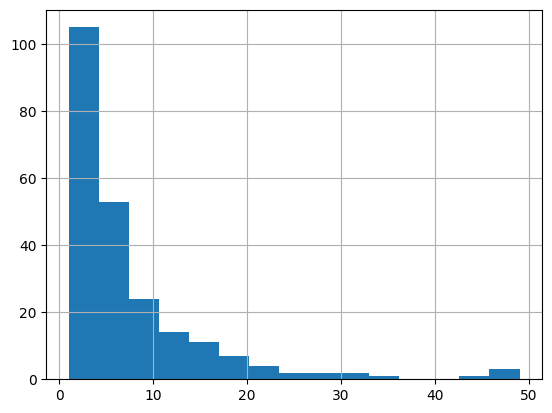

In [10]:
like_click['session_id'].value_counts().hist(bins=15)

In [11]:
sum(like_click['session_id'].value_counts() < 2)

36

In [12]:
view['session_id'].value_counts()

session_id
8551f4b3-5754-47a5-8e0c-99919a5c8a74    1029
04a49069-ce63-4144-9eba-4c6a097281a0     847
fe3b84c2-5dba-4788-bf69-cb7b1ea170f0     639
777d9842-12da-40cf-ab82-1d8f69fba435     512
238e41de-035c-4b10-9174-ca80284e5289     434
                                        ... 
6fabac75-dd43-42c2-ae9b-149d2b17c1d1       9
9c1bed0d-6b2b-47cf-bfe2-ead09a6fb283       3
017a246a-3a3a-43f2-862b-732b3e078d8f       3
30a608e4-1187-48c9-9da1-029907bacfca       3
097b7082-f2c6-4e42-946c-9c8b29f6a2df       3
Name: count, Length: 299, dtype: int64

## Load Metadata

In [13]:
outfit = pd.read_csv("../data/outfit.csv")
outfit.drop(columns=['img_url', 'origin_url', 'reporter'], inplace=True)
outfit

,outfit_id,gender,age,tags,brands,region,occupation,style,date
0,64453,F,NaN,"{반팔 티셔츠,가을,스트릿}",NaN,부산/경남,전문직/프리랜서,스트릿,2020-09-17 00:00:00.000000
1,68758,F,19.0,"{스니커즈,봄,캐주얼,나이키}",{나이키},홍대/신촌,학생,캐주얼,2021-02-24 00:00:00.000000
2,71478,F,22.0,"{여성,셔츠,레더 스커트,워커,여름,캐주얼}",NaN,홍대/신촌,사무직,캐주얼,2021-06-01 00:00:00.000000
3,71480,F,25.0,"{여성,슬리브리스,트랙 팬츠,스니커즈,숄더 백,나이키,여름,로맨틱}",{나이키},홍대/신촌,학생,로맨틱,2021-06-01 00:00:00.000000
4,71482,M,24.0,"{남성,비니,베스트,크로스 백,데님 팬츠,스니커즈,나이키,여름,스트릿}",{나이키},홍대/신촌,패션업,스트릿,2021-06-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...
10424,92177,M,21.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000
10425,92178,F,21.0,"{여름,걸리시}",NaN,홍대/신촌,학생,걸리시,2023-06-29 00:00:00.000000
10426,92179,F,19.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000
10427,92181,F,21.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000


In [14]:
outfit['style'].value_counts()

style
캐주얼         4835
스트릿         2665
걸리시         1379
시크           831
댄디           204
로맨틱          136
아메리칸 캐주얼     134
레트로          129
포멀            79
스포츠           19
고프코어           2
골프             1
Name: count, dtype: int64

In [164]:
# def check_string_inclusion(df: pd.DataFrame, col: str, pattern: str):
#     return df[col].str.contains(pattern).astype(int)

# season_map = {'봄': 'spring', '여름': 'summer', '가을': 'fall', '겨울': 'winter'}
# for 계절, season in season_map.items():
#     outfit[season] = check_string_inclusion(outfit, 'tags', 계절)
# outfit

In [15]:
season_map = {'봄': 'spring', '여름': 'summer', '가을': 'fall', '겨울': 'winter'}
outfit['season'] = np.nan
for 계절 in season_map.keys():
    outfit['season'] = np.where(outfit['tags'].str.contains(계절),
                                계절, outfit['season'])
outfit

,outfit_id,gender,age,tags,brands,region,occupation,style,date,season
0,64453,F,NaN,"{반팔 티셔츠,가을,스트릿}",NaN,부산/경남,전문직/프리랜서,스트릿,2020-09-17 00:00:00.000000,가을
1,68758,F,19.0,"{스니커즈,봄,캐주얼,나이키}",{나이키},홍대/신촌,학생,캐주얼,2021-02-24 00:00:00.000000,봄
2,71478,F,22.0,"{여성,셔츠,레더 스커트,워커,여름,캐주얼}",NaN,홍대/신촌,사무직,캐주얼,2021-06-01 00:00:00.000000,여름
3,71480,F,25.0,"{여성,슬리브리스,트랙 팬츠,스니커즈,숄더 백,나이키,여름,로맨틱}",{나이키},홍대/신촌,학생,로맨틱,2021-06-01 00:00:00.000000,여름
4,71482,M,24.0,"{남성,비니,베스트,크로스 백,데님 팬츠,스니커즈,나이키,여름,스트릿}",{나이키},홍대/신촌,패션업,스트릿,2021-06-01 00:00:00.000000,여름
...,...,...,...,...,...,...,...,...,...,...
10424,92177,M,21.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름
10425,92178,F,21.0,"{여름,걸리시}",NaN,홍대/신촌,학생,걸리시,2023-06-29 00:00:00.000000,여름
10426,92179,F,19.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름
10427,92181,F,21.0,"{여름,스트릿}",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름


In [16]:
outfit['season'].value_counts()

season
봄      3605
여름     3168
겨울     2178
가을     1474
nan       4
Name: count, dtype: int64

In [17]:
outfit['year'] = outfit['date'].str[:4]
outfit['year'].value_counts()

year
2022    6161
2023    3186
2021    1081
2020       1
Name: count, dtype: int64

In [18]:
outfit['brands'] = outfit['brands'].str.replace(r"[{}]", "", regex=True)
outfit['tags'] = outfit['tags'].str.replace(r"[{}]", "", regex=True)
outfit

,outfit_id,gender,age,tags,brands,region,occupation,style,date,season,year
0,64453,F,NaN,"반팔 티셔츠,가을,스트릿",NaN,부산/경남,전문직/프리랜서,스트릿,2020-09-17 00:00:00.000000,가을,2020
1,68758,F,19.0,"스니커즈,봄,캐주얼,나이키",나이키,홍대/신촌,학생,캐주얼,2021-02-24 00:00:00.000000,봄,2021
2,71478,F,22.0,"여성,셔츠,레더 스커트,워커,여름,캐주얼",NaN,홍대/신촌,사무직,캐주얼,2021-06-01 00:00:00.000000,여름,2021
3,71480,F,25.0,"여성,슬리브리스,트랙 팬츠,스니커즈,숄더 백,나이키,여름,로맨틱",나이키,홍대/신촌,학생,로맨틱,2021-06-01 00:00:00.000000,여름,2021
4,71482,M,24.0,"남성,비니,베스트,크로스 백,데님 팬츠,스니커즈,나이키,여름,스트릿",나이키,홍대/신촌,패션업,스트릿,2021-06-01 00:00:00.000000,여름,2021
...,...,...,...,...,...,...,...,...,...,...,...
10424,92177,M,21.0,"여름,스트릿",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023
10425,92178,F,21.0,"여름,걸리시",NaN,홍대/신촌,학생,걸리시,2023-06-29 00:00:00.000000,여름,2023
10426,92179,F,19.0,"여름,스트릿",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023
10427,92181,F,21.0,"여름,스트릿",NaN,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023


In [19]:
outfit['gender'] = outfit['gender'].map({'F': '여성', 'M': '남성'})
outfit['gender'].value_counts()

gender
여성    7381
남성    3048
Name: count, dtype: int64

In [20]:
outfit['brands'].fillna('unknown', inplace=True)
outfit['style'].fillna('unknown', inplace=True)
outfit.isnull().sum()

outfit_id        0
gender           0
age           1440
tags             0
brands           0
region           0
occupation      96
style            0
date             0
season           0
year             0
dtype: int64

In [21]:
def process_tags(row):
    tags = row['tags']
    gender = row['gender']
    brands = row['brands'].split(",")
    style = row['style']
    season = row['season']

    for brand in brands:
        tags = tags.replace(brand, "")
    tags = tags.replace(gender, "").replace(style, "").replace(season, "")
    
    return tags


outfit['tags_'] = outfit.apply(process_tags, axis=1)

In [22]:
outfit

,outfit_id,gender,age,tags,brands,region,occupation,style,date,season,year,tags_
0,64453,여성,NaN,"반팔 티셔츠,가을,스트릿",unknown,부산/경남,전문직/프리랜서,스트릿,2020-09-17 00:00:00.000000,가을,2020,"반팔 티셔츠,,"
1,68758,여성,19.0,"스니커즈,봄,캐주얼,나이키",나이키,홍대/신촌,학생,캐주얼,2021-02-24 00:00:00.000000,봄,2021,"스니커즈,,,"
2,71478,여성,22.0,"여성,셔츠,레더 스커트,워커,여름,캐주얼",unknown,홍대/신촌,사무직,캐주얼,2021-06-01 00:00:00.000000,여름,2021,",셔츠,레더 스커트,워커,,"
3,71480,여성,25.0,"여성,슬리브리스,트랙 팬츠,스니커즈,숄더 백,나이키,여름,로맨틱",나이키,홍대/신촌,학생,로맨틱,2021-06-01 00:00:00.000000,여름,2021,",슬리브리스,트랙 팬츠,스니커즈,숄더 백,,,"
4,71482,남성,24.0,"남성,비니,베스트,크로스 백,데님 팬츠,스니커즈,나이키,여름,스트릿",나이키,홍대/신촌,패션업,스트릿,2021-06-01 00:00:00.000000,여름,2021,",비니,베스트,크로스 백,데님 팬츠,스니커즈,,,"
...,...,...,...,...,...,...,...,...,...,...,...,...
10424,92177,남성,21.0,"여름,스트릿",unknown,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023,","
10425,92178,여성,21.0,"여름,걸리시",unknown,홍대/신촌,학생,걸리시,2023-06-29 00:00:00.000000,여름,2023,","
10426,92179,여성,19.0,"여름,스트릿",unknown,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023,","
10427,92181,여성,21.0,"여름,스트릿",unknown,홍대/신촌,학생,스트릿,2023-06-29 00:00:00.000000,여름,2023,","


In [23]:
outfit['brands'].value_counts()

brands
unknown           7452
나이키                504
컨버스                206
반스                 103
닥터마틴                86
                  ... 
돌체앤가바나               1
아디다스,프라다             1
로사케이                 1
데우스 엑스 마키나,프라다       1
뉴발란스,프라이탁            1
Name: count, Length: 574, dtype: int64

In [24]:
outfit['style'].value_counts(normalize=True)

style
캐주얼         0.463611
스트릿         0.255537
걸리시         0.132227
시크          0.079682
댄디          0.019561
로맨틱         0.013041
아메리칸 캐주얼    0.012849
레트로         0.012369
포멀          0.007575
스포츠         0.001822
unknown     0.001438
고프코어        0.000192
골프          0.000096
Name: proportion, dtype: float64

In [25]:
outfit[outfit['brands']=='unknown']['style'].value_counts(normalize=True)

style
캐주얼         0.413580
스트릿         0.246914
걸리시         0.161702
시크          0.100644
댄디          0.021471
로맨틱         0.016506
레트로         0.014359
아메리칸 캐주얼    0.013017
포멀          0.008857
unknown     0.001476
스포츠         0.001074
고프코어        0.000268
골프          0.000134
Name: proportion, dtype: float64